# check what device we are using, if cuda available we can make labelling faster 

In [1]:
import os
# if using Apple MPS, fall back to CPU for unsupported ops
os.environ["PYTORCH_ENABLE_MPS_FALLBACK"] = "1"
import numpy as np
import torch
import matplotlib
from PIL import Image

In [2]:
# select the device for computation
if torch.cuda.is_available():
    device = torch.device("cuda")
elif torch.backends.mps.is_available():
    device = torch.device("mps")
else:
    device = torch.device("cpu")
print(f"using device: {device}")

if device.type == "cuda":
    # use bfloat16 for the entire notebook
    torch.autocast("cuda", dtype=torch.bfloat16).__enter__()
    # turn on tfloat32 for Ampere GPUs (https://pytorch.org/docs/stable/notes/cuda.html#tensorfloat-32-tf32-on-ampere-devices)
    if torch.cuda.get_device_properties(0).major >= 8:
        torch.backends.cuda.matmul.allow_tf32 = True
        torch.backends.cudnn.allow_tf32 = True
elif device.type == "mps":
    print(
        "\nSupport for MPS devices is preliminary. SAM 2 is trained with CUDA and might "
        "give numerically different outputs and sometimes degraded performance on MPS. "
        "See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion."
    )

using device: mps

Support for MPS devices is preliminary. SAM 2 is trained with CUDA and might give numerically different outputs and sometimes degraded performance on MPS. See e.g. https://github.com/pytorch/pytorch/issues/84936 for a discussion.


# Initiate predictor by loading sam2 weight
1. download weight and place it in ```../checkpoints/```: https://dl.fbaipublicfiles.com/segment_anything_2/092824/sam2.1_hiera_large.pt


In [3]:
from sam2.build_sam import build_sam2_video_predictor

sam2_checkpoint = "../checkpoints/sam2.1_hiera_large.pt"
model_cfg = "configs/sam2.1/sam2.1_hiera_l.yaml"

predictor = build_sam2_video_predictor(model_cfg, sam2_checkpoint, device=device)

In [4]:
def show_mask(mask, ax, obj_id=None, random_color=False):
    if random_color:
        color = np.concatenate([np.random.random(3), np.array([0.6])], axis=0)
    else:
        cmap = plt.get_cmap("tab10")
        cmap_idx = 0 if obj_id is None else obj_id
        color = np.array([*cmap(cmap_idx)[:3], 0.6])
    h, w = mask.shape[-2:]
    mask_image = mask.reshape(h, w, 1) * color.reshape(1, 1, -1)
    ax.imshow(mask_image)


def show_points(coords, labels, ax, marker_size=200):
    pos_points = coords[labels==1]
    neg_points = coords[labels==0]
    ax.scatter(pos_points[:, 0], pos_points[:, 1], color='green', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)
    ax.scatter(neg_points[:, 0], neg_points[:, 1], color='red', marker='*', s=marker_size, edgecolor='white', linewidth=1.25)


def show_box(box, ax):
    x0, y0 = box[0], box[1]
    w, h = box[2] - box[0], box[3] - box[1]
    ax.add_patch(plt.Rectangle((x0, y0), w, h, edgecolor='green', facecolor=(0, 0, 0, 0), lw=2))

In [5]:
from matplotlib.patches import Rectangle
def find_conf(out_mask_logits):
    softmax_thres = 0.5
    per_pixel_mask_prob = torch.sigmoid(out_mask_logits)
    per_pixel_mask_prob = per_pixel_mask_prob - softmax_thres #cut off logits<0.5
    mod = torch.where(per_pixel_mask_prob <0, 0, per_pixel_mask_prob).to('mps')#set each pixel with logit<0.5 to 0
    conf = torch.mean(mod.flatten()) + softmax_thres #add threshold back to reveal real conf
    return conf

def find_bbx(out_mask):
    out = np.squeeze(out_mask)
    bbx_y_range = np.where(out==True)[0]
    bbx_x_range = np.where(out==True)[1]
    y1, y2 = min(bbx_y_range), max(bbx_y_range)
    x1, x2 = min(bbx_x_range), max(bbx_x_range)
    return x1, y1, x2, y2

def plot_bbx_frame(video_dir, frame_names, out_frame_idx, x1, y1, x2, y2, show_img = False, save_fig_root=None):
    if not show_img:
        matplotlib.use('Agg')
        import matplotlib.pyplot as plt
    else:
        import matplotlib.pyplot as plt
    
    w = x2-x1
    h = y2-y1
    fname =frame_names[out_frame_idx]
    fig = plt.figure(figsize=(6, 4), frameon=False)
    ax = plt.Axes(fig, [0., 0., 1., 1.])
    ax.set_axis_off()
    fig.add_axes(ax)
    ax.imshow(Image.open(os.path.join(video_dir, fname)), aspect='auto')
    fig.gca().add_patch(Rectangle((x1,y1),w,h,linewidth=1,edgecolor='r',facecolor='none'))
    if save_fig_root:
        fig.savefig(save_fig_root+fname)
    plt.close(fig)
        
def normalise_bbx(b_center_x, b_center_y, b_width, b_height, image_w, image_h):
    b_center_x /= image_w 
    b_center_y /= image_h 
    b_width    /= image_w 
    b_height   /= image_h 
    return b_center_x, b_center_y, b_width, b_height

def update_print_buffer(x1, y1, x2, y2, image_w, image_h, print_buffer):
    class_id = 0
    b_center_x = (x1+x2)/2
    b_center_y = (y1+y2)/2 
    b_width = x2-x1
    b_height = y2-y1
    b_center_x, b_center_y, b_width, b_height = normalise_bbx(b_center_x, b_center_y, b_width, b_height, image_w, image_h)
    print_buffer.append("{} {:.3f} {:.3f} {:.3f} {:.3f}".format(class_id, b_center_x, b_center_y, b_width, b_height))
    return print_buffer
    

# quickly check if SAM2 gets the right target object in the photos
1. download ```check_balls.csv``` which contains pixel locations of football for all ```vid_*/```, place it in the same directory as this notebook
2. prepare ```./images/association_football_4/test/vid_1/``` ... ```./images/association_football_4/test/vid_13/```, can be downloaded from: https://drive.google.com/file/d/1wGhOzX4ABe5JGcdmNlV-FGLWGTFClC7i/view?usp=share_link



frame loading (JPEG): 100%|█████████████████████| 44/44 [00:01<00:00, 42.12it/s]
/Users/admin/reproduce/sam2_labelling/lib/python3.12/site-packages/torch/nn/functional.py:4594: UserWarning: The operator 'aten::upsample_bicubic2d.out' is not currently supported on the MPS backend and will fall back to run on the CPU. This may have performance implications. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/mps/MPSFallback.mm:13.)
  return torch._C._nn.upsample_bicubic2d(
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_

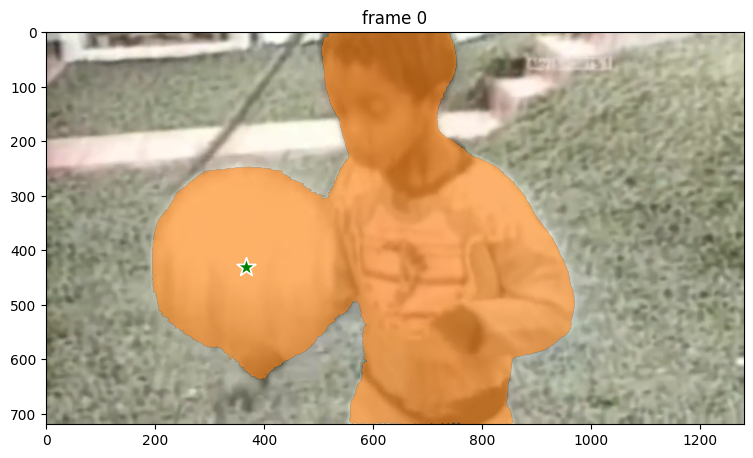

frame loading (JPEG): 100%|███████████████████| 360/360 [00:08<00:00, 43.31it/s]


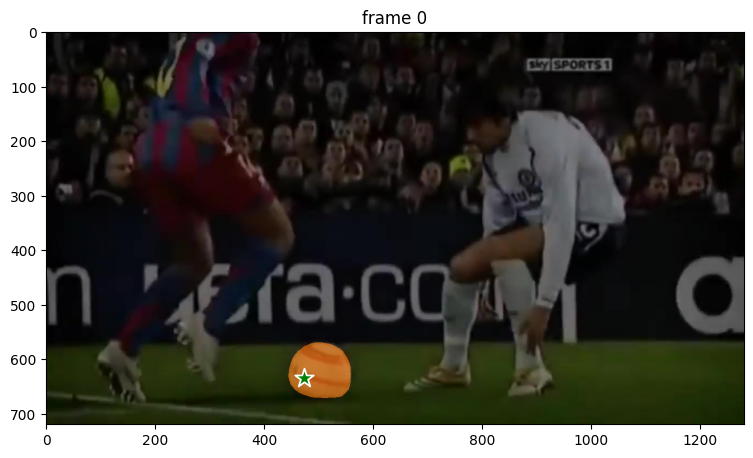

frame loading (JPEG): 100%|███████████████████| 317/317 [00:06<00:00, 46.03it/s]


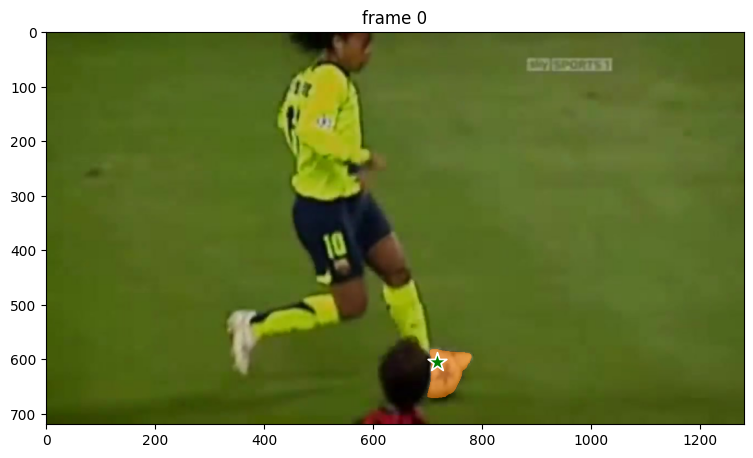

frame loading (JPEG): 100%|███████████████████| 191/191 [00:03<00:00, 50.78it/s]


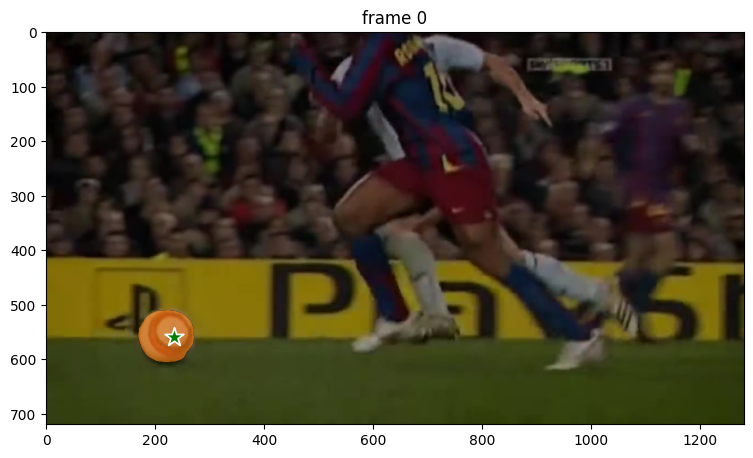

frame loading (JPEG): 100%|███████████████████| 273/273 [00:05<00:00, 51.25it/s]


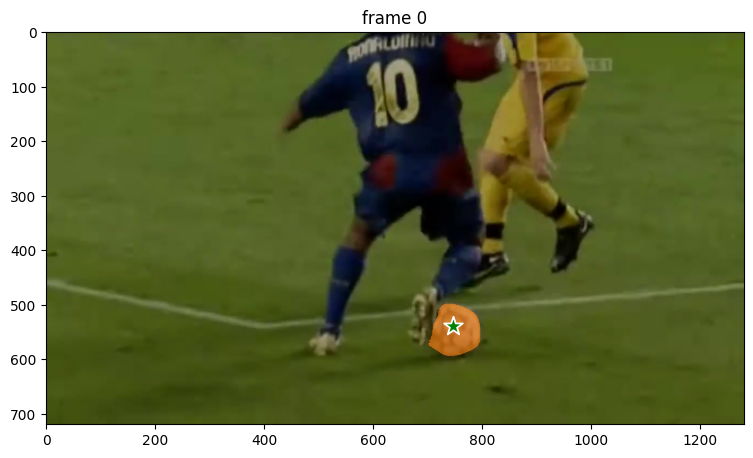

frame loading (JPEG): 100%|███████████████████| 124/124 [00:02<00:00, 47.41it/s]


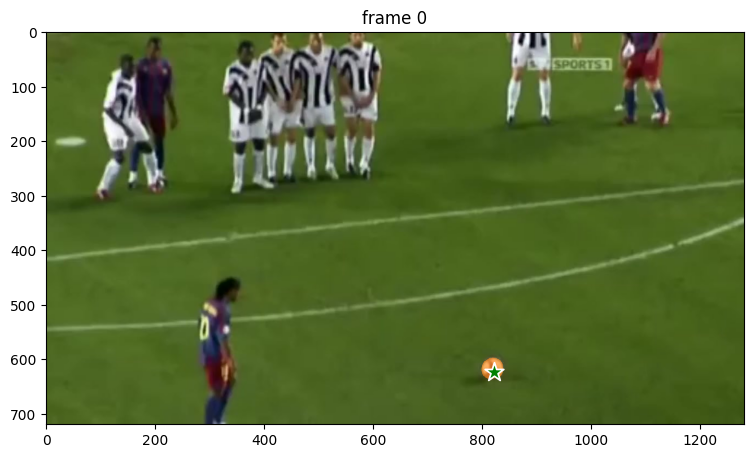

frame loading (JPEG): 100%|███████████████████| 109/109 [00:02<00:00, 46.89it/s]


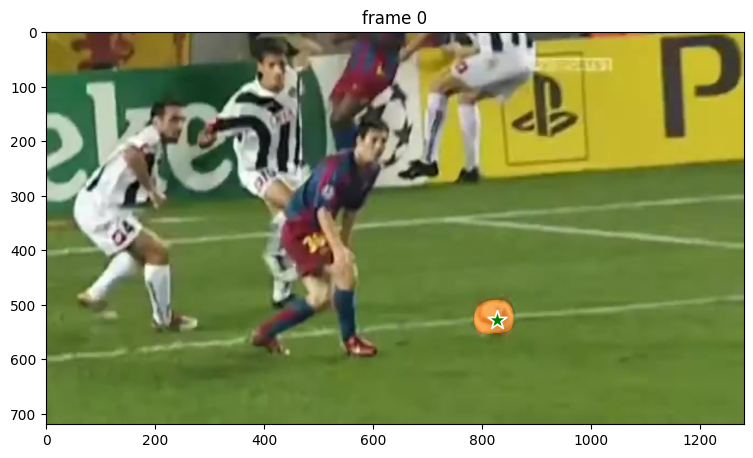

frame loading (JPEG): 100%|█████████████████████| 52/52 [00:01<00:00, 47.22it/s]


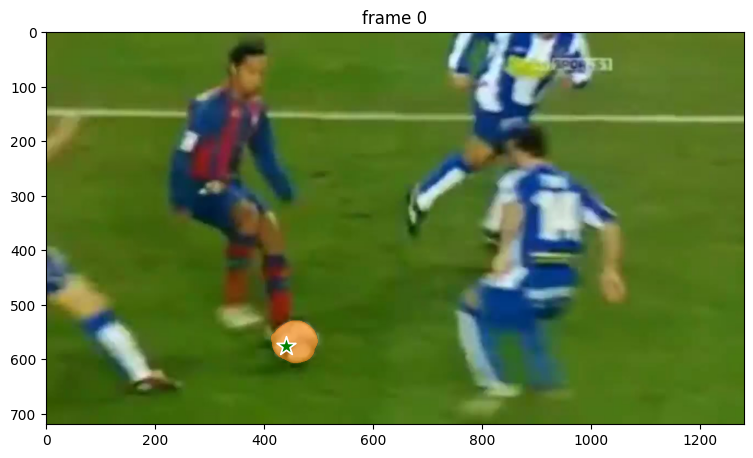

frame loading (JPEG): 100%|███████████████████| 185/185 [00:04<00:00, 46.09it/s]


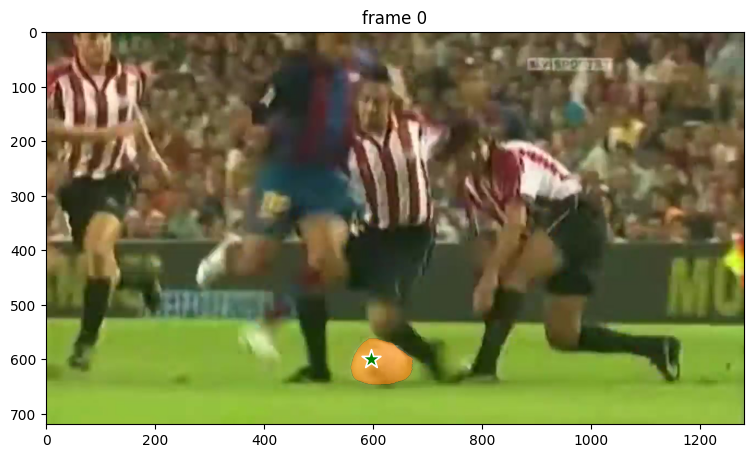

frame loading (JPEG): 100%|███████████████████| 141/141 [00:02<00:00, 48.33it/s]


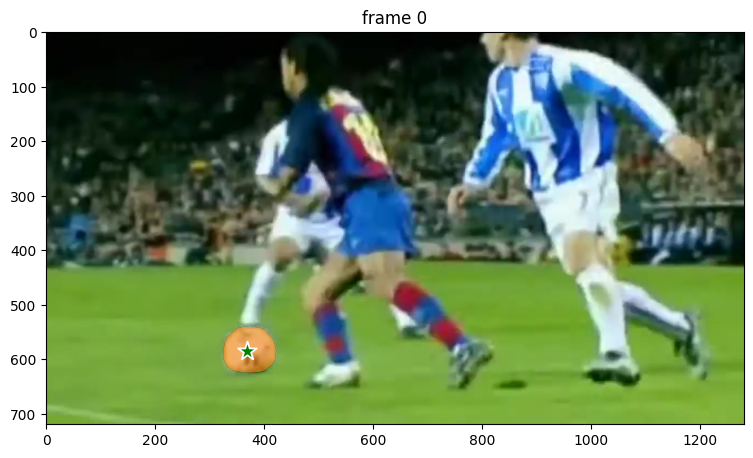

frame loading (JPEG): 100%|███████████████████| 264/264 [00:06<00:00, 41.32it/s]


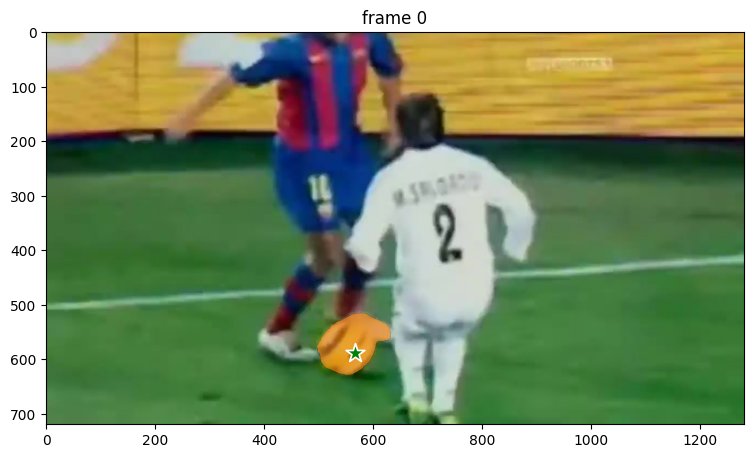

frame loading (JPEG): 100%|███████████████████| 137/137 [00:03<00:00, 44.85it/s]


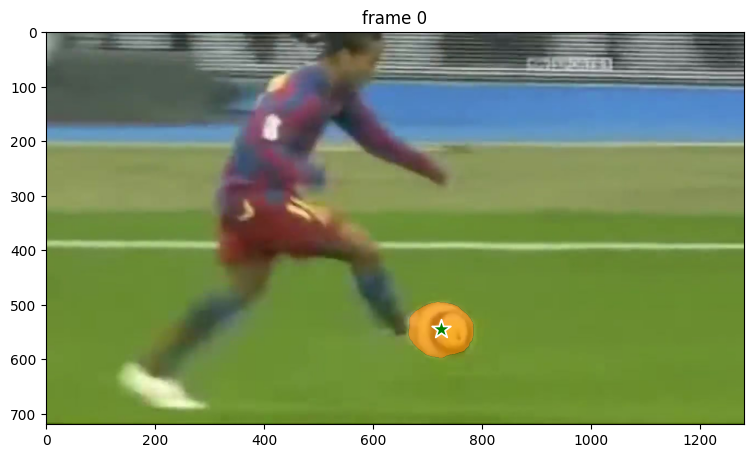

frame loading (JPEG): 100%|███████████████████| 112/112 [00:02<00:00, 46.46it/s]


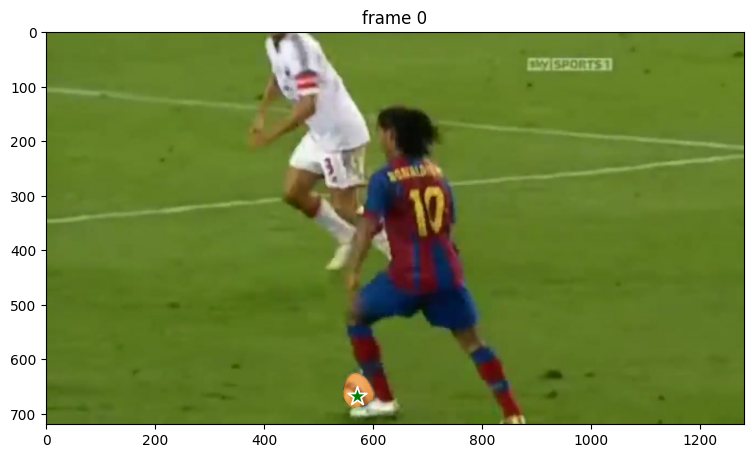

In [6]:
import pandas as pd
import matplotlib.pyplot as plt
df = pd.read_csv('check_balls.csv')
root = './images/association_football_4/'
for i in df['vid']:
    video_dir = root+"test/vid_{0}/".format(i)
    i = i-1
    point_x = int(df['point_x'].iloc[i])
    point_y = int(df['point_y'].iloc[i])
    
    frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))

    """
    reset state
    """
    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)
    
    """
    add reference point and visualise them
    """
    ann_frame_idx = 0  # the frame index we interact with
    ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

    # Let's add a positive click at (x, y) = (210, 350) to get started
    points = np.array([[point_x, point_y]], dtype=np.float32)
    # for labels, `1` means positive click and `0` means negative click
    labels = np.array([1], np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    
    
    plt.figure(figsize=(9, 6))
    plt.title(f"frame {ann_frame_idx}")
    plt.imshow(Image.open(os.path.join(video_dir, frame_names[ann_frame_idx])))
    show_points(points, labels, plt.gca())
    show_mask((out_mask_logits[0] > 0.0).cpu().numpy(), plt.gca(), obj_id=out_obj_ids[0])
    plt.show()
    


# Generate labels and save bbx visualisation (in picture and txt) 
they'll be saved to ``` ./images/association_football_4/annotations/```


### Note: we can ignore warning "cannot find bbx, skip to the next one"


In [7]:
import pandas as pd
import matplotlib
df = pd.read_csv('check_balls.csv')

root = './images/association_football_4/'
skip_vid = [1]#the first one did not look right on SAM2 prediction
for i in df['vid']:
    if i in skip_vid:
        continue
    video_dir = root+"test/vid_{0}/".format(i)
    i = i-1
    point_x = int(df['point_x'].iloc[i])
    point_y = int(df['point_y'].iloc[i])
    
    frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


    """
    reset state
    """
    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)
    
    """
    add reference point and visualise them
    """
    ann_frame_idx = 0  # the frame index we interact with
    ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

    # Let's add a positive click at (x, y) = (210, 350) to get started
    points = np.array([[point_x, point_y]], dtype=np.float32)
    # for labels, `1` means positive click and `0` means negative click
    labels = np.array([1], np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    
    
    """
    generate sam2 predictions
    
    """
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
        
    """
    
    """
    save_fig_root = root+'annotations/'
    if not os.path.exists(save_fig_root):#save Yolov7 label here
        os.mkdir(save_fig_root)

    save_img = True
    show_img = False
    
    vis_frame_stride = 1
    
    try:
        plt.close("all")
    except:
        pass


    for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
        print_buffer = []#to save to yolov7 labels
        img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
        image_w, image_h = img.width, img.height

        if not show_img:
            del img

        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            """
            find bbox
            """
            try:
                x1, y1, x2, y2 = find_bbx(out_mask)
            except:
                print('cannot find bbx, skip to the next one')
                continue
            print_buffer = update_print_buffer(x1, y1, x2, y2, image_w, image_h, print_buffer)

            """
            plot bbox
            """
            plot_bbx_frame(video_dir, frame_names, out_frame_idx, x1, y1, x2, y2, show_img = False, save_fig_root=save_fig_root)

        """
        output mask to YOLOv7 bbox format
        """
        if len(print_buffer)>0:
            save_file_name = os.path.join(save_fig_root, frame_names[out_frame_idx].replace("jpg", "txt"))
            print("\n".join(print_buffer), file= open(save_file_name, "w"))

frame loading (JPEG): 100%|███████████████████| 360/360 [00:07<00:00, 45.54it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 360/360 [16:22<00:00,  2.73s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 317/317 [00:07<00:00, 42.40it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 317/317 [15:06<00:00,  2.86s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 191/191 [00:03<00:00, 49.50it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
frame loading (JPEG): 100%|███████████████████| 273/273 [00:05<00:00, 48.91it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limit

cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find 

frame loading (JPEG): 100%|███████████████████| 124/124 [00:02<00:00, 51.86it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 124/124 [03:52<00:00,  1.87s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 109/109 [00:02<00:00, 52.54it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 109/109 [03:53<00:00,  2.14s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|█████████████████████| 52/52 [00:00<00:00, 52.32it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
frame loading (JPEG): 100%|███████████████████| 185/185 [00:03<00:00, 49.15it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limit

cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 141/141 [00:02<00:00, 47.55it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 141/141 [04:39<00:00,  1.98s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 264/264 [00:05<00:00, 49.62it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 264/264 [10:00<00:00,  2.28s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 137/137 [00:02<00:00, 49.00it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 137/137 [04:43<00:00,  2.07s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one


frame loading (JPEG): 100%|███████████████████| 112/112 [00:02<00:00, 48.75it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 112/112 [03:22<00:00,  1.81s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find 

# Move the first 600 bbx photos&txt for building train/val set
# The remaining bbx photos&txt go to pseudo_annotated set


In [8]:
print('BBx photos and .txt files are here: {0}'.format(save_fig_root))


BBx photos and .txt files are here: ./images/association_football_4/annotations/


In [18]:
import os
import glob

txt_li = glob.glob(save_fig_root+'*.txt')
ID_li = [i.split('/')[-1].split('.')[0] for i in txt_li]
ID_li.sort()

In [21]:
train_val_folder = save_fig_root+'train_val/'
if not os.path.exists(train_val_folder):
    os.mkdir(train_val_folder)

In [25]:
pseudo_annotated_folder = save_fig_root+'pseudo_annotated/'
if not os.path.exists(pseudo_annotated_folder):
    os.mkdir(pseudo_annotated_folder)

In [26]:
types = ['.txt', '.jpg']
index = 600
for ID in ID_li[:index]:
    for t in types:
        src = save_fig_root+ID+t
        dst = train_val_folder+ID+t
        os.rename(src, dst)
        
for ID in ID_li[index:]:
    for t in types:
        src = save_fig_root+ID+t
        dst = pseudo_annotated_folder+ID+t
        os.rename(src, dst)    

# use label.py to verify labels in train_val_folder
1. ```label.py``` can be downloaded from: https://drive.google.com/file/d/1zZmsVoBmEOlGVdMtJTkpRH68UjdKIuL4/view?usp=share_link, place it in ```sam2/notebooks/```
2. in command line: ```python label.py ./images/association_football_4/annotations/train_val/```
2. now in train_val_folder, aka ```./images/association_football_4/annotations/train_val/```, there are two subfolds: ```yes/``` and ```no/```
3. good labels (bbx images & txt) go to ```yes/```, bad ones go to ```no/```

In [28]:
os.listdir(train_val_folder)

['.DS_Store', 'no', 'yes']

3. remove ```no/``` folder

In [49]:
!rm -f -r ./images/association_football_4/annotations/train_val/no

4. remove bbx photos for both ```train_val/``` and ```pseudo_annotated/```

In [46]:
for f in glob.glob(train_val_folder+'yes/*.jpg'):
    os.remove(f)

In [48]:
for f in glob.glob(pseudo_annotated_folder+'*.jpg'):
    os.remove(f)

## prepare a ```labels/``` subfolder for both ```train_val/``` and ```pseudo_annotated/```

4. rename train_val_folder+```'yes/``` to ```labels/```

In [50]:
!mv ./images/association_football_4/annotations/train_val/yes ./images/association_football_4/annotations/train_val/labels

5. create a labels folder in ```pseudo_annotated/``` and move all ```.txt``` in it

In [55]:
pseudo_labels_folder = pseudo_annotated_folder+'labels/'
if not os.path.exists(pseudo_labels_folder):
    os.mkdir(pseudo_labels_folder)

In [56]:
for pth in glob.glob(pseudo_annotated_folder+'*.txt'):
    f = pth.split('/')[-1]
    os.rename(pth, pseudo_labels_folder+f)

## prepare a ```images/``` subfolder for both ```train_val/``` and ```pseudo_annotated/```

In [59]:
pseudo_images_folder = pseudo_annotated_folder+'images/'
if not os.path.exists(pseudo_images_folder):
    os.mkdir(pseudo_images_folder)

### move images from root+```test/vid_*/``` to ```test/```, and remove empty```test/vid_*/```

In [70]:
def myfunc(n):
    digit = int(n.split('_')[-1])
    return abs(digit)

vid_li = sorted(glob.glob(root+'test/*'), key= myfunc)

In [76]:
for vid in vid_li:
    src = glob.glob(vid+'/*.jpg')
    for s in src:
        fname = s.split('/')[-1]
        dst = root+'test/'+fname
        os.rename(s, dst)

In [84]:
import shutil
for vid in vid_li:
    shutil.rmtree(vid)

## move images from root+```test/``` to corresponding train_val_images_folder or pseudo_images_folder

In [86]:
train_val_folder

'./images/association_football_4/annotations/train_val/'

In [88]:
trainval_labels_folder = train_val_folder+'labels'
trainval_images_folder = train_val_folder+'images'

In [92]:
label_pths = glob.glob(trainval_labels_folder+'/*.txt')
for l in label_pths:
    fname = l.split('/')[-1]
    name = fname.split('.')[0]
    img_src = root+'test/'+name+'.jpg'
    img_dst = trainval_images_folder+'/'+name+'.jpg'
    os.rename(img_src, img_dst)

In [105]:
def move_imgs(labels_folder, images_folder):
    """
    move imgs from inside root+'test/' to images_folder, using fname without extension in labels_folders
    
    example:
        root = './images/association_football_4/'
        src = root+'test/00568.jpg'
        images_folder = root+'annotations/pseudo_annotated/images/'
        dst = images_folder+'00568.jpg'
    
    """
    
    label_pths = glob.glob(labels_folder+'/*.txt')
    for l in label_pths:
        fname = l.split('/')[-1]
        name = fname.split('.')[0]
        img_src = root+'test/'+name+'.jpg'
        img_dst = images_folder+'/'+name+'.jpg'
        os.rename(img_src, img_dst)
        

In [106]:
labels_folder = pseudo_labels_folder
images_folder = pseudo_images_folder
move_imgs(labels_folder, images_folder)

# label the remaining data from ```test/```

Note: at this moment, we might still have some photos in ```test/```, I use SAM2 to label them and put them to pseudo_annotated_folder. Since we don't mind the label quality of these images, we don't visualise SAM2 predictions. 


In [118]:
import matplotlib

"""
1. redefine video_dir and iterate jpg
2. redefine point_x and point_y
3. redefine save_fig_root 
4. set save_fig_root=None in plot_bbx_frame function
4. the rest are not changed
"""

video_dir = './images/association_football_4/test/'#change this line
for i in glob.glob(video_dir):
    point_x = 366 #change this line
    point_y = 431 #change this line
    
    frame_names = [
    p for p in os.listdir(video_dir)
    if os.path.splitext(p)[-1] in [".jpg", ".jpeg", ".JPG", ".JPEG"]]
    frame_names.sort(key=lambda p: int(os.path.splitext(p)[0]))


    """
    reset state
    """
    inference_state = predictor.init_state(video_path=video_dir)
    predictor.reset_state(inference_state)
    
    """
    add reference point and visualise them
    """
    ann_frame_idx = 0  # the frame index we interact with
    ann_obj_id = 1  # give a unique id to each object we interact with (it can be any integers)

    # Let's add a positive click at (x, y) = (210, 350) to get started
    points = np.array([[point_x, point_y]], dtype=np.float32)
    # for labels, `1` means positive click and `0` means negative click
    labels = np.array([1], np.int32)
    _, out_obj_ids, out_mask_logits = predictor.add_new_points_or_box(
        inference_state=inference_state,
        frame_idx=ann_frame_idx,
        obj_id=ann_obj_id,
        points=points,
        labels=labels,
    )
    
    
    """
    generate sam2 predictions
    
    """
    video_segments = {}  # video_segments contains the per-frame segmentation results
    for out_frame_idx, out_obj_ids, out_mask_logits in predictor.propagate_in_video(inference_state):
        video_segments[out_frame_idx] = {
            out_obj_id: (out_mask_logits[i] > 0.0).cpu().numpy()
            for i, out_obj_id in enumerate(out_obj_ids)
        }
        
    """
    
    """
    save_fig_root = video_dir+'annotations/'
    if not os.path.exists(save_fig_root):#save Yolov7 label here
        os.mkdir(save_fig_root)

    save_img = True
    show_img = False
    
    vis_frame_stride = 1
    
    try:
        plt.close("all")
    except:
        pass


    for out_frame_idx in range(0, len(frame_names), vis_frame_stride):
        print_buffer = []#to save to yolov7 labels
        img = Image.open(os.path.join(video_dir, frame_names[out_frame_idx]))
        image_w, image_h = img.width, img.height

        if not show_img:
            del img

        for out_obj_id, out_mask in video_segments[out_frame_idx].items():
            """
            find bbox
            """
            try:
                x1, y1, x2, y2 = find_bbx(out_mask)
            except:
                print('cannot find bbx, skip to the next one')
                continue
            print_buffer = update_print_buffer(x1, y1, x2, y2, image_w, image_h, print_buffer)

            """
            plot bbox
            """
            plot_bbx_frame(video_dir, frame_names, out_frame_idx, x1, y1, x2, y2, show_img = False, save_fig_root=None)#at this point we don't save bbx imgs

        """
        output mask to YOLOv7 bbox format
        """
        if len(print_buffer)>0:
            save_file_name = os.path.join(save_fig_root, frame_names[out_frame_idx].replace("jpg", "txt"))
            print("\n".join(print_buffer), file= open(save_file_name, "w"))

frame loading (JPEG): 100%|███████████████████| 239/239 [00:04<00:00, 48.42it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video: 100%|█████████████████████| 239/239 [26:51<00:00,  6.74s/it]


cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find bbx, skip to the next one
cannot find 

frame loading (JPEG): 100%|███████████████████| 239/239 [00:04<00:00, 51.31it/s]
/Users/admin/reproduce/sam2/sam2/sam2_video_predictor.py:961: UserWarning: cannot import name '_C' from 'sam2' (/Users/admin/reproduce/sam2/sam2/__init__.py)

Skipping the post-processing step due to the error above. You can still use SAM 2 and it's OK to ignore the error above, although some post-processing functionality may be limited (which doesn't affect the results in most cases; see https://github.com/facebookresearch/sam2/blob/main/INSTALL.md).
  pred_masks_gpu = fill_holes_in_mask_scores(
propagate in video:  25%|█████▌                | 60/239 [06:45<20:10,  6.76s/it]


KeyboardInterrupt: 

move generated txt files to pseudo_labels_folder

In [125]:
for src in glob.glob(root+'test/annotations/*txt'):
    fname = src.split('/')[-1]
    dst = pseudo_labels_folder+fname
    os.rename(src, dst)

move image files to pseudo_images_folder

In [126]:
for src in glob.glob(root+'test/*.jpg'):
    fname = src.split('/')[-1]
    dst = pseudo_images_folder+fname
    os.rename(src, dst)

remove root+'test/, as it is empty

In [127]:
!rm -f -r ./images/association_football_4/test/

# move pseudo_annotated/ and train_val/ to root

In [128]:
!mv './images/association_football_4/annotations/pseudo_annotated/' './images/association_football_4/pseudo_annotated/'

In [129]:
!mv './images/association_football_4/annotations/train_val/' './images/association_football_4/train_val/'

remove root+ annotations/ as it is empty

In [130]:
!rm -f -r './images/association_football_4/annotations/'

#### split ```train_val/images/``` to ```train_val/images/train/``` and ```train_val/images/val/```

In [133]:
train_val_folder #not exist anymore

'./images/association_football_4/annotations/train_val/'

In [135]:
train_val_folder = './images/association_football_4/train_val/' #update to new path
folder_li = ['train/', 'val/']
for fold in folder_li:
    if not os.path.exists(train_val_folder+'images/'+fold):
        os.mkdir(train_val_folder+'images/'+fold)

In [152]:
import random 
trainval_IDs = [i.split('/')[-1].split('.')[0] for i in glob.glob(train_val_folder+'labels/*txt')]
print(len(trainval_IDs))#honestly it should be 600 files here, yikes...
random.seed(1)
ratio = 0.3#val get 30 percent of data
val_IDs = random.sample(trainval_IDs, int(len(trainval_IDs)*ratio))
train_IDs = [i for i in trainval_IDs if i not in val_IDs]

569


In [153]:
print(len(val_IDs)+len(train_IDs) == len(trainval_IDs))

True


In [158]:
for v in val_IDs:
    src = train_val_folder+'images/'+v+'.jpg'
    dst = train_val_folder+'images/'+'val/'+v+'.jpg'
    os.rename(src, dst)

In [162]:
the_rest_imgs = glob.glob(train_val_folder+'images/*.jpg')
for src in the_rest_imgs:
    f = src.split('/')[-1]
    dst = train_val_folder+'images/'+'train/'+f
    os.rename(src, dst)

### split ```train_val/labels/``` to ```train_val/labels/train/``` and ```train_val/labels/val/```

In [163]:
for fold in folder_li:
    if not os.path.exists(train_val_folder+'labels/'+fold):
        os.mkdir(train_val_folder+'labels/'+fold)

In [164]:
for v in val_IDs:
    src = train_val_folder+'labels/'+v+'.txt'
    dst = train_val_folder+'labels/'+'val/'+v+'.txt'
    os.rename(src, dst)

In [166]:
the_rest_txt = glob.glob(train_val_folder+'labels/*.txt')
for src in the_rest_txt:
    f = src.split('/')[-1]
    dst = train_val_folder+'labels/'+'train/'+f
    os.rename(src, dst)

# split validation set for generating test set

In [2]:
import os
train_val_folder = './images/association_football_4/train_val/'
fold = 'test/'
pairs = ['labels/', 'images/']
for p in pairs:
    if not os.path.exists(train_val_folder+p+fold):
        os.mkdir(train_val_folder+p+fold)


In [6]:
import glob
import random
val_IDs = [i.split('/')[-1].split('.')[0] for i in glob.glob(train_val_folder+'labels/val/*txt')]
random.seed(1)
ratio = 0.5
new_val_IDs = random.sample(val_IDs, int(len(val_IDs)*ratio))
test_IDs = [i for i in val_IDs if i not in new_val_IDs]

for ID in test_IDs:
    src = train_val_folder+'labels/val/'+ID+'.txt'
    dst = train_val_folder+'labels/test/'+ID+'.txt'
    os.rename(src, dst)

In [7]:
for ID in test_IDs:
    src = train_val_folder+'images/val/'+ID+'.jpg'
    dst = train_val_folder+'images/test/'+ID+'.jpg'
    os.rename(src, dst)

In [8]:
train_val_folder 

'./images/association_football_4/train_val/'

### rename ```./images/association_football_4/train_val/'``` to ```./images/association_football_4/train_val_test/```

In [9]:
!mv './images/association_football_4/train_val/' './images/association_football_4/train_val_test/'

# clean imgs that don't have labels

since there was no gurantee on SAM2 would find a mask target, 
we have to trim images if corresponding .txt files don't exist

In [5]:
train_val_test = './images/association_football_4/train_val_test/'
pseudo_annotated_folder = './images/association_football_4/pseudo_annotated/'

In [57]:
def remove_imgs(img_folder, txt_folder):
    count = 0
    for i in glob.glob(img_folder+'*.jpg'):
        ID = i.split('/')[-1].split('.')[0]
        txt = ID+'.txt'
        img = ID+'.jpg'
        if not os.path.exists(txt_folder+txt):
            os.remove(img_folder+img)
            count+=1
    print('remove {0} imgs'.format(count))
    

In [56]:
import glob
import os
img_folder = pseudo_annotated_folder +'images/'
txt_folder = pseudo_annotated_folder +'labels/'
remove_imgs(img_folder, txt_folder)

remove 156 imgs


In [58]:
fold_li = ['train/', 'val/', 'test/']
for fold in fold_li:
    img_folder = train_val_test +'images/' +fold
    txt_folder = train_val_test +'labels/' +fold
    remove_imgs(img_folder, txt_folder)

remove 0 imgs
remove 0 imgs
remove 0 imgs


# Now our Yolov7 custom dataset is prepared
what's next? 
1. copy ```train_val_test/``` to Yolov7 root folder
2. copy ```pseudo_annotated/``` to Yolov7 root folder